In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 6.5 MB 36.7 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 895 kB 54.0 MB/s 
     |████████████████████████████████| 596 kB 65.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch

In [ ]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('mrm8488/spanbert-finetuned-squadv2')

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('mrm8488/spanbert-finetuned-squadv2')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

In [ ]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [ ]:
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 76 tokens.


In [ ]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
How           1,731
many          1,242
parameters   11,934
does          1,674
B               139
##ER          9,637
##T           1,942
-               118
large         1,415
have          1,138
?               136

[SEP]           102

B               139
##ER          9,637
##T           1,942
-               118
large         1,415
is            1,110
really        1,541
big           1,992
.               119
.               119
.               119
it            1,122
has           1,144
24            1,572
-               118
layers        8,798
and           1,105
an            1,126
em            9,712
##bed         4,774
##ding        3,408
size          2,060
of            1,104
1               122
,               117
02            5,507
##4           1,527
,               117
for           1,111
a               170
total         1,703
of            1,104
340          16,984
##M           2,107
parameters   11,934
!               106
Alto         17,76

In [ ]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [ ]:
# Run our example through the model.
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True) 

start_scores = outputs.start_logits
end_scores = outputs.end_logits


In [ ]:
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "340 ##M"


In [ ]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "340M"


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


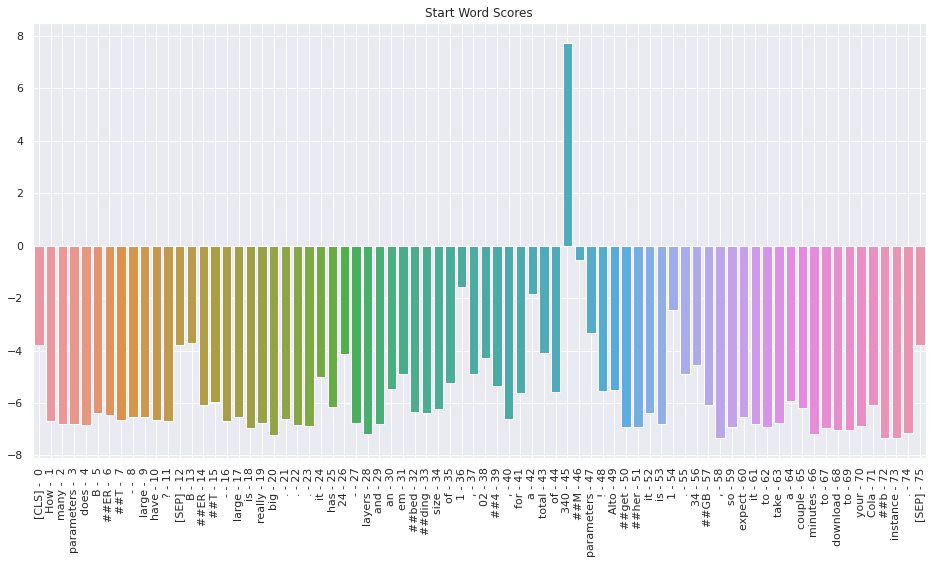

In [ ]:
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

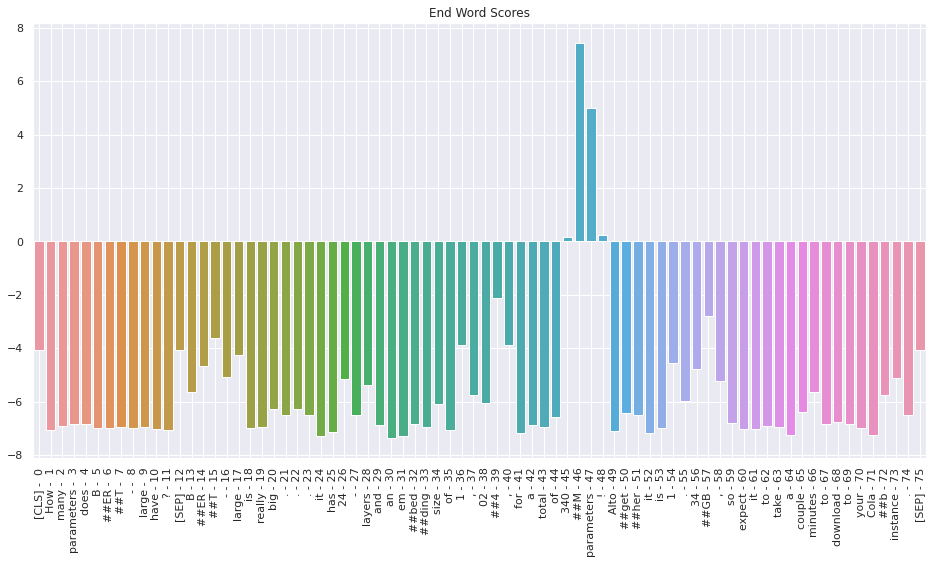

In [ ]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [ ]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


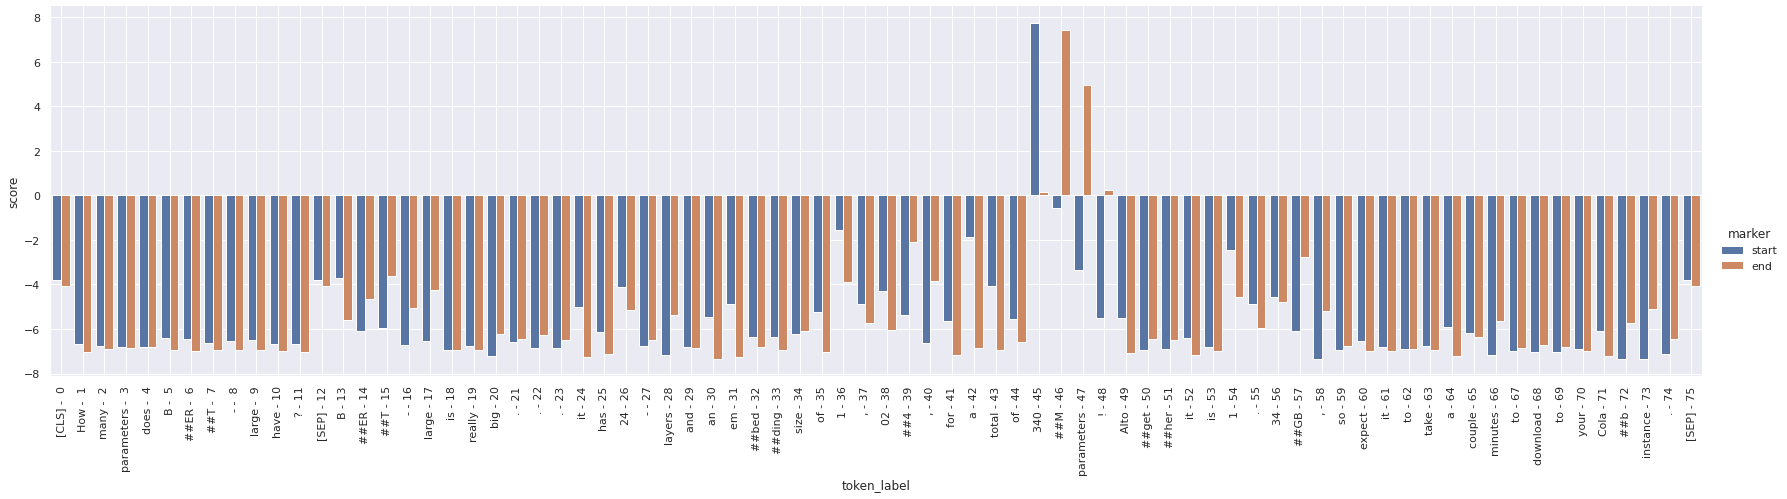

In [ ]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


In [ ]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    tokenizer.model_max_length = 512
    input_ids = tokenizer.encode(question, answer_text,truncation = True,padding = True)

    # Report how long the input sequence is.

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    return  answer

    

In [ ]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."
print(len(bert_abstract))

1064


In [ ]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)


'Bidirectional Encoder Representations from Transformers'

In [ ]:
question = "What are some example applications of BERT?"

Answer1 = answer_question(question, bert_abstract)
print('"' + Answer1 + '"')

"question answering and language inference"


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [ ]:
class SquadExample(object):
    """
    A single training/test example for the Squad dataset.
    For examples without an answer, the start and end position are -1.
    """

    def __init__(self,
                 qas_id,
                 question_text,
                 paragraph_text,
                 doc_tokens,
                 answers_text = None,
                 orig_answer_text=None,
                 start_position=None,
                 end_position=None,
                 is_impossible=None):
        self.qas_id = qas_id
        self.question_text = question_text
        self.paragraph_text = paragraph_text
        self.doc_tokens = doc_tokens
        self.answers_text = answers_text
        self.orig_answer_text = orig_answer_text
        self.start_position = start_position
        self.end_position = end_position
        self.is_impossible = is_impossible

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        s = ""
        s += "qas_id: %s" % (self.qas_id)
        s += ", question_text: %s" % (
            self.question_text)
        s += ", paragraph_text: %s" % (
            self.paragraph_text)
        s += ", doc_tokens: [%s]" % (" ".join(self.doc_tokens))
        if self.start_position:
            s += ", start_position: %d" % (self.start_position)
        if self.end_position:
            s += ", end_position: %d" % (self.end_position)
        if self.is_impossible:
            s += ", is_impossible: %r" % (self.is_impossible)
        return s

In [ ]:
rows = []
def read_squad_examples(input_file, is_training, version_2_with_negative):
    """Read a SQuAD json file into a list of SquadExample."""
    with open(input_file, "r", encoding='utf-8') as reader:
        input_data = json.load(reader)["data"]

    def is_whitespace(c):
        if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
            return True
        return False

    examples = []
    for entry in input_data:
        for paragraph in entry["paragraphs"]:
            paragraph_text = paragraph["context"]
            doc_tokens = []
            char_to_word_offset = []
           
            prev_is_whitespace = True
            for c in paragraph_text:
                if is_whitespace(c):
                    prev_is_whitespace = True
                else:
                    if prev_is_whitespace:
                        doc_tokens.append(c)
                    else:
                        doc_tokens[-1] += c
                    prev_is_whitespace = False
                char_to_word_offset.append(len(doc_tokens) - 1)

            for qa in paragraph["qas"]:
                qas_id = qa["id"]
                question_text = qa["question"]
                start_position = None
                end_position = None
                orig_answer_text = None
                is_impossible = False
                answers = qa['answers']
                if is_training:
                    if version_2_with_negative:
                        is_impossible = qa["is_impossible"]
                    if (len(qa["answers"]) != 1) and (not is_impossible):
                        raise ValueError(
                            "For training, each question should have exactly 1 answer.")
                    if not is_impossible:
                        answer = qa["answers"][0]
                        orig_answer_text = answer["text"]
                        answer_offset = answer["answer_start"]
                        answer_length = len(orig_answer_text)
                        start_position = char_to_word_offset[answer_offset]
                        end_position = char_to_word_offset[answer_offset + answer_length - 1]
                        actual_text = " ".join(doc_tokens[start_position:(end_position + 1)])
                        cleaned_answer_text = " ".join(
                            whitespace_tokenize(orig_answer_text))
                        if actual_text.find(cleaned_answer_text) == -1:
                            logger.warning("Could not find answer: '%s' vs. '%s'",
                                           actual_text, cleaned_answer_text)
                            continue
                    else:
                        start_position = -1
                        end_position = -1
                        orig_answer_text = ""
                if is_training == False:
                  
                  if version_2_with_negative:
                        is_impossible = qa["is_impossible"]
                  
                  if len(answers) > 0:
                          answers = [a['text'] for a in answers]
                          rows.append(answers)
                  else:
                      rows.append([""])
                example = SquadExample(
                    qas_id=qas_id,
                    question_text=question_text,
                    paragraph_text = paragraph_text,
                    doc_tokens=doc_tokens,
                    orig_answer_text=orig_answer_text,
                    start_position=start_position,
                    end_position=end_position,
                    is_impossible=is_impossible)
                examples.append(example)
    return examples

In [ ]:
def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens

In [ ]:
import json
examples = read_squad_examples('/content/squad/dev-v2.0.json', False, 'version_2_with_negative')

In [ ]:
rows[9]

['William the Conqueror', 'William the Conqueror', 'William the Conqueror']

In [ ]:
question = examples[3105].question_text
context = examples[3105].paragraph_text
answer_question(question, context)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


'EU law'

In [ ]:
Answers2 = []
for i in range(len(examples)):
  print(i)
  question = examples[i].question_text
  context = examples[i].paragraph_text
  if(examples[i].is_impossible == False):
    Answer1 = answer_question(question, context)
    Answers2.append(Answer1)
  else:
    print("hii")
    Answers2.append("")

0
1
2
3
4
5
hii
6
hii
7
hii
8
hii
9
10
11
12
hii
13
hii
14
hii
15
hii
16
hii
17
18
19
hii
20
hii
21
22
23
24
hii
25
hii
26
hii
27
hii
28
29
hii
30
hii
31
32
33
hii
34
hii
35
hii
36
37
hii
38
hii
39
hii
40
41
hii
42
hii
43
hii
44
hii
45
46
47
48
hii
49
hii
50
hii
51
hii
52
53
54
55
hii
56
hii
57
hii
58
hii
59
60
hii
61
hii
62
hii
63
64
65
66
hii
67
hii
68
hii
69
hii
70
71
72
73
hii
74
hii
75
hii
76
77
78
79
hii
80
hii
81
hii
82
83
84
85
86
hii
87
hii
88
hii
89
90
91
92
hii
93
hii
94
hii
95
96
97
98
99
hii
100
hii
101
hii
102
hii
103
104
hii
105
hii
106
hii
107
108
109
110
hii
111
hii
112
hii
113
114
115
116
117
hii
118
hii
119
hii
120
121
122
hii
123
hii
124
125
126
127
hii
128
hii
129
130
hii
131
hii
132
133
134
hii
135
hii
136
hii
137
hii
138
139
140
141
hii
142
hii
143
144
hii
145
hii
146
147
148
149
150
hii
151
hii
152
hii
153
154
155
156
hii
157
hii
158
hii
159
160
hii
161
hii
162
163
164
165
hii
166
hii
167
168
169
hii
170
hii
171
hii
172
173
174
hii
175
176
177
178
hii
179
hii
18

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3100
hii
3101
hii
3102
hii
3103
hii
3104
hii
3105


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3106


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3107


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3108


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3109


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3110
3111
hii
3112
hii
3113
hii
3114
hii
3115
3116
3117
3118
3119
3120
hii
3121
hii
3122
hii
3123
hii
3124
hii
3125
3126
3127
3128


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3129
hii
3130
hii
3131
hii
3132
hii
3133
hii
3134
3135
3136
3137
3138
hii
3139
hii
3140
hii
3141
3142
3143
3144


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3145
hii
3146
hii
3147
hii
3148
hii
3149


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3150


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3151


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3152


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3153
3154
hii
3155
hii
3156
hii
3157
hii
3158
hii
3159
3160
3161
3162
3163
hii
3164
hii
3165
hii
3166
hii
3167
hii
3168
3169
3170
hii
3171
hii
3172
hii
3173
hii
3174
3175
3176
3177
hii
3178
hii
3179
hii
3180
hii
3181
hii
3182
3183
3184
3185
3186
hii
3187
hii
3188
hii
3189
hii
3190
hii
3191
3192
3193
hii
3194
hii
3195
hii
3196
hii
3197
3198
3199
3200
3201
3202
hii
3203
hii
3204
hii
3205
hii
3206
hii
3207
3208
3209
3210
3211
hii
3212
hii
3213
hii
3214
hii
3215
hii
3216
3217
3218
3219
3220
3221
hii
3222
hii
3223
hii
3224
hii
3225
hii
3226
3227
3228
3229
3230
hii
3231
hii
3232
hii
3233
hii
3234
hii
3235
3236
3237
3238
3239
3240
hii
3241
hii
3242
hii
3243
hii
3244
hii
3245
3246
3247
3248
3249
3250
hii
3251
hii
3252
hii
3253
hii
3254
hii
3255
3256
3257
3258
3259
hii
3260
hii
3261
hii
3262
hii
3263
hii
3264
3265
3266
3267
3268


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3269
hii
3270
hii
3271
hii
3272
hii
3273
hii
3274


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3275


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3276


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3277


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3278


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3279
hii
3280
hii
3281
hii
3282
hii
3283
hii
3284


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3285


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3286


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3287


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3288


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3289
hii
3290
hii
3291
hii
3292
hii
3293


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3294


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3295


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3296
3297
hii
3298
hii
3299
hii
3300
hii
3301
3302
3303
3304
3305


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3306
hii
3307
hii
3308
hii
3309
hii
3310
hii
3311


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3312


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3313


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3314


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3315
3316
hii
3317
hii
3318
hii
3319
hii
3320
hii
3321
3322
3323
3324
3325
hii
3326
hii
3327
hii
3328
hii
3329
3330
3331
3332
3333
3334
hii
3335
hii
3336
hii
3337
hii
3338
hii
3339
3340
3341
3342


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3343
hii
3344
hii
3345
hii
3346
hii
3347


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3348


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3349


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3350


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3351
hii
3352
hii
3353
hii
3354
hii
3355
hii
3356


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3357


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3358


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3359


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3360
3361
hii
3362
hii
3363
hii
3364
hii
3365
hii
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
hii
3382
hii
3383
hii
3384
hii
3385
hii
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
hii
3402
hii
3403
hii
3404
hii
3405
hii
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
hii
3422
hii
3423
hii
3424
hii
3425
hii
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
hii
3441
hii
3442
hii
3443
hii
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
hii
3460
hii
3461
hii
3462
hii
3463
hii
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
hii
3479
hii
3480
hii
3481
hii
3482
hii
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
hii
3494
hii
3495
hii
3496
hii
3497
hii
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
hii
3509
hii
3510
hii
3511
hii
3512
hii
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
hii


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4396
hii
4397
hii
4398
hii
4399
hii
4400
hii
4401
hii
4402
hii
4403
hii
4404
hii
4405
hii
4406
hii
4407
hii
4408
hii
4409
hii
4410


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4411


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4412


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4413
4414
hii
4415
hii
4416
hii
4417
hii
4418
hii
4419
hii
4420
hii
4421
hii
4422
hii
4423
hii
4424
4425
4426
4427
4428
hii
4429
hii
4430
hii
4431
hii
4432
hii
4433
hii
4434
hii
4435
hii
4436
hii
4437
4438
4439
4440
4441
hii
4442
hii
4443
hii
4444
hii
4445
hii
4446
hii
4447
hii
4448
hii
4449
hii
4450
4451
4452
4453
4454
hii
4455
hii
4456
hii
4457
hii
4458
hii
4459
hii
4460
hii
4461
hii
4462
hii
4463
4464
4465
4466
4467
hii
4468
hii
4469
hii
4470
hii
4471
hii
4472
hii
4473
hii
4474
hii
4475
hii
4476
hii
4477
4478
4479
4480
4481
hii
4482
hii
4483
hii
4484
hii
4485
hii
4486
hii
4487
hii
4488
hii
4489
4490
4491
4492
hii
4493
hii
4494
hii
4495
hii
4496
hii
4497
hii
4498
hii
4499
hii
4500
hii
4501
hii
4502
4503
4504
4505
4506
4507
hii
4508
hii
4509
hii
4510
hii
4511
hii
4512
hii
4513
hii
4514
hii
4515
hii
4516
4517
4518
4519
4520
4521
hii
4522
hii
4523
hii
4524
hii
4525
hii
4526
hii
4527
hii
4528
hii
4529
hii
4530
hii
4531
4532
4533
4534
hii
4535
hii
4536
hii
4537
hii
4538
hii
4539
hii
4540


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


5247
hii
5248
hii
5249
hii
5250
hii
5251


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


5252


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


5253


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


5254


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Streaming output truncated to the last 5000 lines.
8515
8516
8517
8518
hii
8519
hii
8520
hii
8521
hii
8522
hii
8523
8524
8525
8526
8527
8528
hii
8529
hii
8530
hii
8531
hii
8532
hii
8533
8534
8535
8536
8537
8538
hii
8539
hii
8540
hii
8541
hii
8542
hii
8543
8544
8545
8546
8547
8548
hii
8549
hii
8550
hii
8551
hii
8552
hii
8553
8554
8555
8556
8557
8558
hii
8559
hii
8560
hii
8561
hii
8562
hii
8563
8564
8565
8566
8567
hii
8568
hii
8569
hii
8570
hii
8571
hii
8572
8573
8574
8575
8576
hii
8577
hii
8578
hii
8579
hii
8580
hii
8581
8582
8583
8584
8585
hii
8586
hii
8587
hii
8588
hii
8589
8590
8591
8592
8593
8594
hii
8595
hii
8596
hii
8597
hii
8598
hii
8599
8600
8601
8602
8603
hii
8604
hii
8605
hii
8606
hii
8607
hii
8608
8609
8610
8611
8612
8613
hii
8614
hii
8615
hii
8616
hii
8617
hii
8618
8619
8620
8621
8622
8623
hii
8624
hii
8625
hii
8626
hii
8627
hii
8628
8629
8630
8631
8632
8633
hii
8634
hii
8635
hii
8636
hii
8637
hii
8638
8639
8640
8641
8642
hii
8643
hii
8644
hii
8645
hii
8646
hii
8647
8648
864

In [ ]:
rows[8]

['']

In [ ]:
print(Answers2[1])

10th and 11th centuries


In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import regex as re
import collections
import string
#define array of actual classes
actual = "vasuki nadapana"

#define array of predicted classes
pred = "vasuki"

#calculate F1 score
def compute_f1(actual, pred):
    gold_toks = get_tokens(actual)
    pred_toks = get_tokens(pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def normalize_answer(s):

    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()
f1 = compute_f1(actual, pred)
print(f1)

0.6666666666666666


In [ ]:
!pip install tqdm
import tqdm
k = 0
print(len(Answers2))
F1_values = []
while(k < len(Answers2)):
  #print(k)
  #print(values[k])
  sum1 = 0
  #print(actual_values[k])
  
  for w in rows[k]:
    f1 = compute_f1(w ,Answers2[k])
    sum1 = sum1 + f1
  F1_values.append(sum1/len(rows[k]))
  k = k + 1

11873


In [ ]:
print(len(F1_values))

11873


In [ ]:
print(F1_values)

[1.0, 0.9722222222222222, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.7777777777777777, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.7777777777777777, 0.7777777777777777, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.44973544973544977, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333332, 0.0, 1.0, 0.037037037037037035, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 0.9523809523809524, 0.9333333333333332, 0.8888888888888888, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [ ]:
sum1 = 0
for i in F1_values:
  sum1 = sum1 + i
sum1 = sum1 / len(F1_values) 
print(sum1*100)

85.98045130609496
